### This notebook illustrates how to gate number and brightness analysis (N&B)
Note that this uses photon counting mode data.  Note that you need to have movie.tif from the sim_movie simulation (or from experimental data) loaded into your workspace.  This shows how to gate the N&B data to highlight parts of the image based on oligomerization.  Gate coordinate generation will hopefully be interactive at some point.
Click here to open in google colab: http://colab.research.google.com/github/jayunruh/pysimfcs/blob/main/gate_n_and_b.ipynb

In [1]:
#if you are using this from google colab, you need the utility modules
#(everything else should already be installed)
import os
if(not os.path.exists('pysimfcs_utils.py')):
    print('downloading pysimfcs libraries')
    !wget https://raw.githubusercontent.com/jayunruh/pysimfcs/refs/heads/main/pysimfcs_utils.py
if(not os.path.exists('analysis_utils.py')):
    !wget https://raw.githubusercontent.com/jayunruh/pysimfcs/refs/heads/main/analysis_utils.py
else:
    print('libraries already downloaded')

libraries already downloaded


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import scipy.ndimage as ndi
import analysis_utils as simutils
from matplotlib import patches

In [3]:
#get the jet colormap with the under values set to white
ncmap=simutils.getncmap()
#get the red colormap for masking
rcmap=simutils.getsinglecmap('red')

In [4]:
#read in our simulated movie
simstack=tifffile.imread('movie.tif')
simstack.shape

(256, 2, 64, 64)

In [5]:
#here we calculate all of the number and brightness statistic images
sms=2 #the smoothing standard deviation
thresh=0.0 #the threshold for calculating I and B
avg=simstack.mean(axis=0)
var=simstack.var(axis=0)
covar=simutils.covar(simstack[:,0],simstack[:,1])
bright=var/avg-1.0
coavg=np.sqrt(avg[0]*avg[1])
cobright=covar/coavg
mask=avg<thresh #this is a boolean mask image denoting the threshold
#set the regions outside the mask to nan
avg[mask]=np.nan
bright[mask]=np.nan
coavg[mask[0]]=np.nan
cobright[mask[0]]=np.nan
#now do the smoothing
avgsm=ndi.gaussian_filter(avg,sigma=[0,sms,sms])
brightsm=ndi.gaussian_filter(bright,sigma=[0,sms,sms])
coavgsm=ndi.gaussian_filter(coavg,sigma=sms)
cobrightsm=ndi.gaussian_filter(cobright,sigma=sms)

In [6]:
#get the autoscale information
amax=avg.max()*1.1
brightmax=bright.max()*1.1
print('max average',amax,'max brightness',brightmax)

max average 22.476953125 max brightness 8.07248960533263


In [7]:
plotavgmax=amax #change this to change the x dimensions of the histogram
plotbrightmax=brightmax #change this to change the y dimensions of the histogram
bins=(np.linspace(0,plotavgmax,64),np.linspace(0,plotbrightmax,64))

In [8]:
gatepoly=np.array([[10,2.2],[20,2.25],[20,5.1],[10,5.0]])

Text(0, 0.5, 'Brightness')

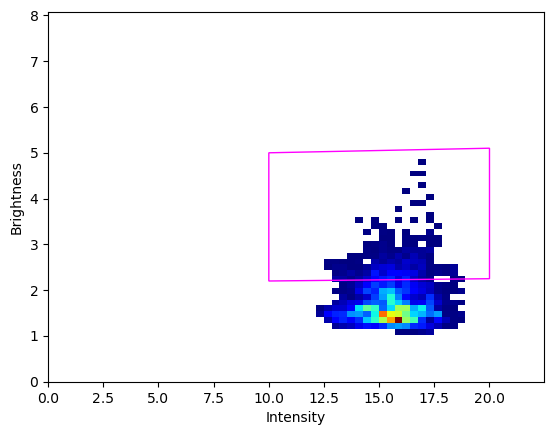

In [13]:
_=plt.hist2d(avgsm[0].flat,brightsm[0].flat,bins=bins,cmap=ncmap,vmin=1)
polygon=plt.Polygon(gatepoly,closed=True,ec='magenta',fill=False)
polygon=plt.gca().add_patch(polygon)
plt.xlabel('Intensity')
plt.ylabel('Brightness')

In [10]:
#get the values inside the gate as a boolean image
gated=simutils.polyContains(gatepoly,np.array([avgsm[0].flat,brightsm[0].flat]).T).reshape(avgsm[0].shape)

/Users/jru/Documents/IPython_Notebooks/pysimfcs/analysis_utils.py:509: RuntimeWarning: divide by zero encountered in divide
  mask=((polygon[i,0]>=y)!=(polygon[r1[i],0]>=y)) & (x>(polygon[r1[i],1]-polygon[i,1])*(y-polygon[i,0])/(polygon[r1[i],0]-polygon[i,0])+polygon[i,1])


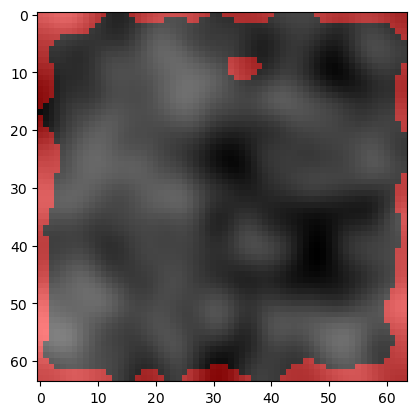

In [11]:
#show the masked region as an overlay
plt.imshow(avgsm[0],cmap='gray')
plt.imshow(gated,alpha=0.5,cmap=rcmap)

Text(0.5, 1.0, 'avg image')

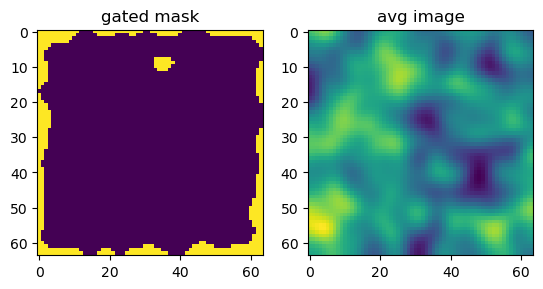

In [12]:
#show the masked region side by side
ax=plt.subplot(1,2,1)
ax.imshow(gated)
ax.set_title('gated mask')
ax=plt.subplot(1,2,2)
ax.imshow(avgsm[0])
ax.set_title('avg image')